# Загрузим данные и нужные библиотеки

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, mannwhitneyu, shapiro
from scipy.stats import chi2_contingency, chi2

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

In [2]:
# Инфо о пользователях
active_users = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/B4QnY5D5EtKa-A')

# Доход с пользователей
purchases = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/AmucCdboEaowhA')

# Разбивка по группам на контрольную (А) и тестовую (В)
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/jP_BAw_oxS3law')

# Проверка данных

In [3]:
print('Количество пустых значений в данных о группах -',groups.isna().sum().sum())
print('Количество дубликатов -', groups.duplicated().sum(),'\n')

print('Количество уникальных значений -', groups.user_id.nunique(), '\n')

df_groups = groups.group.value_counts(normalize=True).mul(100)

print('Количество пользователей в группе А -', groups[groups['group'] == 'A'].shape[0], 
      ', что составляет', df_groups.A.round(2), '% от всех пользователей.')
print('Количество пользователей в группе B -', groups[groups['group'] == 'B'].shape[0], 
      ', что составляет', df_groups.B.round(2), '% от всех пользователей.')

Количество пустых значений в данных о группах - 0
Количество дубликатов - 0 

Количество уникальных значений - 74576 

Количество пользователей в группе А - 14693 , что составляет 19.7 % от всех пользователей.
Количество пользователей в группе B - 59883 , что составляет 80.3 % от всех пользователей.


Всего уникальных пользователей - 74576, из них в контрольной группе примерно 20% от всех пользователей,
в тестовой - 80% всех пользователей. 

Следовательно, пользователей в группе B больше в 4 раза, чем в группе А, что говорит о ненормальном распределении.

In [4]:
print('Количество пустых значений в данных об активных пользователях -',active_users.isna().sum().sum())
print('Количество дубликатов -', active_users.duplicated().sum(),'\n')
print('Количество уникальных значений -', active_users.user_id.nunique())

Количество пустых значений в данных об активных пользователях - 0
Количество дубликатов - 0 

Количество уникальных значений - 8341


In [5]:
print('Количество пустых значений в данных об оплате -',purchases.isna().sum().sum())
print('Количество дубликатов -', purchases.duplicated().sum(),'\n')
print('Количество уникальных значений -', purchases.user_id.nunique())

Количество пустых значений в данных об оплате - 0
Количество дубликатов - 0 

Количество уникальных значений - 541


**Рассмотрим подробнее данные об оплате**

In [6]:
payment_data = purchases.merge(active_users, on = 'user_id', how = 'left').merge(groups, on = 'user_id', how = 'left')
payment_data['country'] =payment_data['country'].fillna(0)

print('Пользователи, которые не заходили во время эксперемента, но внесли оплату: \n')
print('Группа А:',payment_data.query('country == 0 and group == "A"').count()[0])
print('Группа B:',payment_data.query('country == 0 and group == "B"').count()[0], '\n')
print('Пользователи, которые заходили во время эксперемента и внесли оплату: \n')
print('Группа А:',payment_data.query('country != 0 and group == "A"').count()[0])
print('Группа B:',payment_data.query('country != 0 and group == "B"').count()[0])

Пользователи, которые не заходили во время эксперемента, но внесли оплату: 

Группа А: 29
Группа B: 120 

Пользователи, которые заходили во время эксперемента и внесли оплату: 

Группа А: 78
Группа B: 314


Некоторые пользователи, которые не заходили в приложение, выбирали новую модель оплаты. Без их согласия им не могли поменять способ оплаты. 

Следовательно, либо они выбирали модель и оплачивали вне приложения, либо у них стоит продление подписки, либо это ошибка при сборе данных об активных пользователях.

Значит, для анализа мы не можем исключать пользователей, которые не заходили в приложение во время эксперемента.

# Обработка данных

**Проверим влияние факторов у активных пользователей. Чтобы понять, учитывать ли эти данные при общем анализе.**

In [7]:
general_data = active_users.merge(purchases, on = 'user_id', how = 'outer').merge(groups, on = 'user_id', how = 'outer')
general_data['revenue'] = general_data['revenue'].fillna(0)

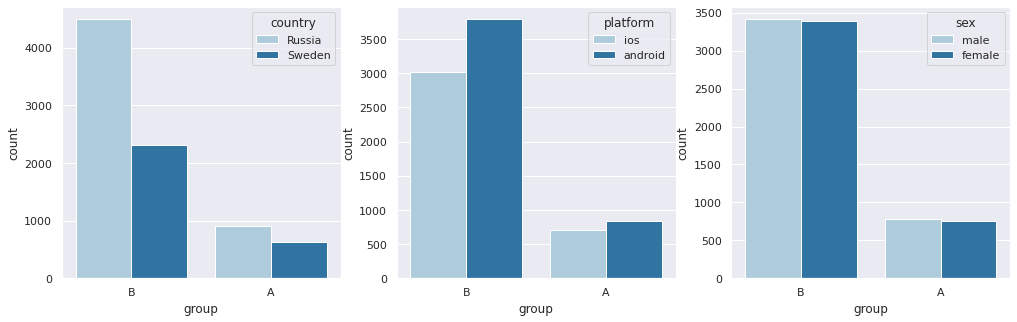

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (17,5))
ax = sns.color_palette("Paired")

sns.countplot(data = general_data, x = 'group', hue = 'country', palette = ax, ax = axes[0])
sns.countplot(data = general_data, x = 'group', hue = 'platform', palette = ax, ax = axes[1])
sns.countplot(data = general_data, x = 'group', hue = 'sex', palette = ax, ax = axes[2])

На графиках виден дисбаланс в группах **country** и **platform**.


Поэтому нужно понять, есть ли отличия в экономических показателях в зависимости от факторов.

# A/A-тестирование

Для проверки наших выборок проведём тест **хи-квадрат**.

Так как у нас две категориальные переменные: 
- $1$ - принадлежность к тестовой или контрольной группе;
- $2$ - принадлежность к одной из групп.

**Зависимость выборки по странам**

In [9]:
aa_country = pd.crosstab(general_data.group, general_data.country)
stat, p, dof, expected = chi2_contingency(aa_country)
print('p-value = ', p, '\n')
if p <= 0.05:
    print('Выборки независимы друг от друга.')
else:
    print('Выборки зависимы между собой.')

p-value =  1.4440642250057943e-06 

Выборки независимы друг от друга.


Так как выборка тестовой групп по странам была независима от контрольной, мы будем проводить A/B-тест с разделением по странам и  сравнивать их между собой.

**Зависимость выборки по платформам**

In [10]:
aa_platform = pd.crosstab(general_data.group, general_data.platform)
stat, p, dof, expected = chi2_contingency(aa_platform)
print('p-value = ', p, '\n')
if p <= 0.05:
    print('Выборки независимы друг от друга.')
else:
    print('Выборки зависимы между собой.')

p-value =  0.31833776540573483 

Выборки зависимы между собой.


Следовательно, платформу можно не учитывать при анализе.

**Зависимость выборки по полу**

In [11]:
aa_sex = pd.crosstab(general_data.group, general_data.sex)
stat, p, dof, expected = chi2_contingency(aa_sex)
print('p-value = ', p, '\n')
if p <= 0.05:
    print('Выборки независимы друг от друга.')
else:
    print('Выборки зависимы между собой.')

p-value =  0.5420161465061012 

Выборки зависимы между собой.


Так же, как и с платформами, пол пользователей мы учитывать не будем.

# A/B-тестирование

# CR - Конверсия пользователя в клиента (в покупку) по группам

                                                   Общие данные

In [12]:
cr_a = general_data.query('revenue > 0 and group == "A"').user_id.count() \
/general_data.query('group == "A"').user_id.count() * 100
print('Конверсия в контрольной группе: ', cr_a.round(2), '%')

cr_b = general_data.query('revenue > 0 and group == "B"').user_id.count() \
/general_data.query('group == "B"').user_id.count() * 100
print('Конверсия в тестовой группе: ', cr_b.round(2), '%')

Конверсия в контрольной группе:  0.73 %
Конверсия в тестовой группе:  0.72 %


Доля платящих пользователей в тестовой и в контрольной группах примерно одинакова.

Чтобы убедиться в этом, сделаем тест **хи-квадрат**.

Так как у нас две категориальные переменные: 
- $1$ - принадлежность к тестовой или контрольной группе;
- $2$ - факта оплаты.

Сформулируем гипотезы:
- $H_0$: конверсии в группе A и B **одинаковые**;
- $H_1$: конверсии в группе A и B **разные**.

In [13]:
general_data['purchases'] = general_data.revenue.apply(lambda x: 1 if x>0 else 0)

                                                       Russia

In [14]:
cr_russia = pd.crosstab(general_data.query('country == "Russia"').group, general_data.query('country == "Russia"').purchases)
stat, p, dof, expected = chi2_contingency(cr_russia)
print('p-value = ', p)

if p <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value =  0.7397861776034413

Уровень значимости больше 0.05
Не отклоняем H0


                                                       Sweden

In [15]:
cr_sweden = pd.crosstab(general_data.query('country == "Sweden"').group, general_data.query('country == "Sweden"').purchases)
stat, p, dof, expected = chi2_contingency(cr_sweden)
print('p-value = ', p)

if p <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value =  0.6504727896095026

Уровень значимости больше 0.05
Не отклоняем H0


                                                Неактивные пользователи

In [16]:
cr_nan = pd.crosstab(general_data.query('country != "Sweden" and country != "Russia"').group, 
                     general_data.query('country != "Sweden" and country != "Russia"').purchases)
stat, p, dof, expected = chi2_contingency(cr_nan)
print('p-value = ', p)

if p <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value =  0.9847399648396614

Уровень значимости больше 0.05
Не отклоняем H0


Тест показал, что статистически значимых различий нет. 

Значит, эксперимент не повлиял на конверсию пользователя в клиента.

# Вывод по CR:

Данный эксперимент не повлиял на увеличение конверсии ни в одном из случаев.

Следовательно, количество пользователей, которые готовы платить за продукт, не изменилось.

# ARPPU - Средняя выручка на одного платящего пользователя

                                                   Общие данные

In [17]:
arppu_a = general_data.query('group == "A"').revenue.sum() / general_data.query('group == "A" and revenue > 0').revenue.count()
print('ARPPU контрольной группы:', arppu_a.round(2))

arppu_b = general_data.query('group == "B"').revenue.sum() / general_data.query('group == "B" and revenue > 0').revenue.count()
print('ARPPU тестовой группы:',arppu_b.round(2))

ARPPU контрольной группы: 870.67
ARPPU тестовой группы: 1118.84


Средняя выручка с платящего пользователя в тестовой группе выше, чем в контрольной на 248.17.

Из чего следует, что в тестовой группе клиенты готовы были заплатить большую сумму за предложение, чем в контрольной.

# 1 часть

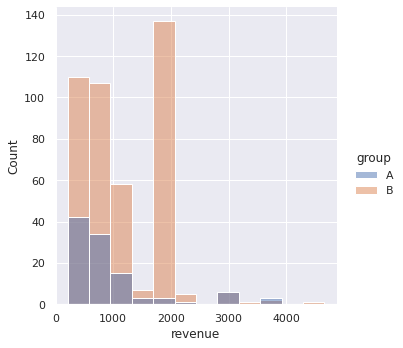

In [18]:
sns.displot(data=general_data.query('revenue > 0'), x='revenue', hue='group')

На графике видно, что распределение выручки среди групп не является нормальным.

Чтобы убедиться в этом, сделаем тест **Шапиро-Уилка**.

Сформулируем гипотезы:
- $H_0$: тестовая и контрольная группы **распределены нормально**;
- $H_1$: тестовая и контрольная группы **распределены не нормально**.

                                                       Russia

In [19]:
p1 = shapiro(general_data.query('group == "A" and revenue > 0 and country == "Russia"') \
             .revenue.sample(1000, replace = True))[1]
p2 = shapiro(general_data.query('group == "B" and revenue > 0 and country == "Russia"') \
             .revenue.sample(1000, replace = True))[1]
print('p-value контрольной группы:', p1)

if p1 <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

print('\np-value тестовой группы:',p2)

if p2 <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value контрольной группы: 1.4414956916828995e-38

Уровень значимости меньше 0.05
Отклоняем H0

p-value тестовой группы: 2.3466941186098345e-28

Уровень значимости меньше 0.05
Отклоняем H0


                                                       Sweden

In [20]:
p1 = shapiro(general_data.query('group == "A" and revenue > 0 and country == "Sweden"') \
             .revenue.sample(1000, replace = True))[1]
p2 = shapiro(general_data.query('group == "B" and revenue > 0 and country == "Sweden"') \
             .revenue.sample(1000, replace = True))[1]

print('p-value контрольной группы:', p1)

if p1 <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

print('\np-value тестовой группы:',p2)

if p2 <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value контрольной группы: 5.813073834346199e-35

Уровень значимости меньше 0.05
Отклоняем H0

p-value тестовой группы: 4.477178872903434e-30

Уровень значимости меньше 0.05
Отклоняем H0


                                                 Неактивные пользователи

In [21]:
p1 = shapiro(general_data.query('group == "A" and revenue > 0 and country != "Sweden" and country != "Russia"') \
             .revenue.sample(1000, replace = True))[1]
p2 = shapiro(general_data.query('group == "B" and revenue > 0 and country != "Sweden" and country != "Russia"') \
             .revenue.sample(1000, replace = True))[1]
print('p-value контрольной группы:', p1)

if p1 <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

print('\np-value тестовой группы:',p2)

if p2 <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value контрольной группы: 3.4382497118101724e-33

Уровень значимости меньше 0.05
Отклоняем H0

p-value тестовой группы: 8.787917224916877e-28

Уровень значимости меньше 0.05
Отклоняем H0


Распределение выручки не является нормальным, так как уровень значимости во всех случаях меньше 0.05

# 2 часть

Поэтому будем применять тест **Манна-Уитни**

Сформулируем гипотезы:
- $H_0$: средние чеки в контрольной и тестовой группах **эквивалентны**;
- $H_1$: средние чеки в контрольной и тестовой группах **различны**.

                                                       Russia

In [22]:
p = mannwhitneyu(general_data.query('group == "A" and revenue > 0 and country == "Russia"').revenue, 
                   general_data.query('group == "B" and revenue > 0 and country == "Russia"').revenue)[1]
print('p-value =', p)

if p <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value = 0.0014699816493472517

Уровень значимости меньше 0.05
Отклоняем H0


                                                       Sweden

In [23]:
p = mannwhitneyu(general_data.query('group == "A" and revenue > 0 and country == "Sweden"').revenue, 
                   general_data.query('group == "B" and revenue > 0 and country == "Sweden"').revenue)[1]
print('p-value =', p)

if p <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value = 0.03958280081671394

Уровень значимости меньше 0.05
Отклоняем H0


Уровень значимости меньше 0.05 в случаях, когда мы значем, из какой страны пользователь.

Следовательно, мы **отклоняем нулевую гипотезу** о равенстве средних чеков в случае с Russia и Sweden.

Итог: 
- $1$ - обе страны показали примерно одинаковые результаты теста, поэтому их можно не разделять при проверки бутстрапом;
- $2$ - средние чеки в контрольной и тестовой группах различны.

                                                 Неактивные пользователи

In [24]:
p = mannwhitneyu(general_data.query('group == "A" and revenue > 0 and country != "Sweden" and country != "Russia"').revenue, 
                   general_data.query('group == "B" and revenue > 0 and country != "Sweden" and country != "Russia"').revenue)[1]
print('p-value =', p)

if p <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')

p-value = 0.32858504025883084

Уровень значимости больше 0.05
Не отклоняем H0


В случае с пользователями, которые не заходили во время эксперимента в приложение - средний чек не увеличился.
Следовательно, в этом случае мы не можем отклонить нулевую гипотезу.

# 3 часть

**Проверим гипотезу с помощью Bootstrap**

In [25]:
def get_bootstrap(
    control, 
    test, 
    statistic,
    boot_it, 
    boot_conf_level = 0.95
):
    boot_len = max([len(control), len(test)])
    boot_data = []
    for i in range(boot_it):
        samples_1 = control.sample(boot_len, replace = True).values
        samples_2 = test.sample(boot_len, replace = True).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)

    # Доверительный интервал:
    
    left_quant = (1 - boot_conf_level)/2
    right_quant = 1 - (1 - boot_conf_level)/2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data))
        
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data))
        
    p_value = min(p_1, p_2) * 2
    
        
    # Визуализация:
    
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return{"boot_data": boot_data, "ci": ci, "p_value": p_value}

                                                 Активные пользователи

In [26]:
control = general_data.query('revenue > 0 and group == "A" and (country == "Sweden" or country == "Russia")').revenue
test = general_data.query('revenue > 0 and group == "B" and (country == "Sweden" or country == "Russia")').revenue

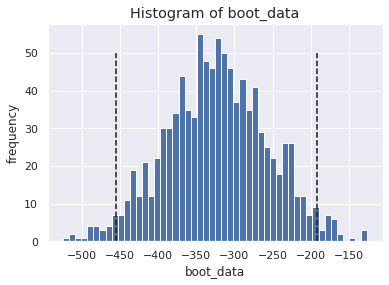

p_value =  1.3698530093103236e-06

Уровень значимости меньше 0.05
Отклоняем H0


,0
0.025,-454.505175
0.975,-191.778583


In [27]:
booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.mean)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

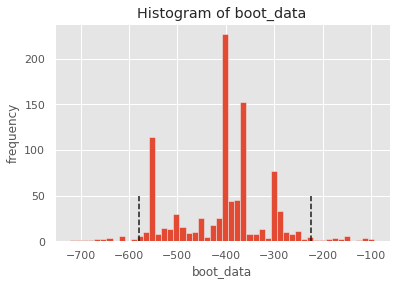

p_value =  2.4853633603022395e-05

Уровень значимости меньше 0.05
Отклоняем H0


,0
0.025,-578.5000
0.975,-224.9875


In [28]:
booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.median)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

Можно заметить, что на обоих графиках (с медианой и со средним значениями) 0 не попадает в доверительный интервал.

На это указывает и значение уровня значимости, в обоих случях меньше 0.05

Следовательно, нулевая гипотеза о равенстве средних чеков между активными пользователями **не принимается**. 

**Итог:** ARPPU тестовой группы больше, чем ARPPU контрольной.

                                                 Неактивные пользователи

In [29]:
control = general_data.query('revenue > 0 and group == "A" and country != "Sweden" and country != "Russia"').revenue
test = general_data.query('revenue > 0 and group == "B" and country != "Sweden" and country != "Russia"').revenue

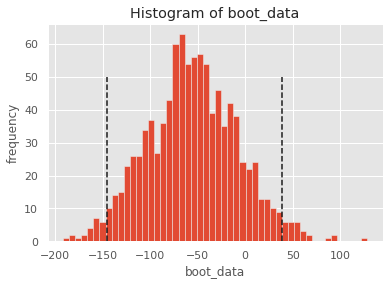

p_value =  0.241159533045058

Уровень значимости больше 0.05
Не отклоняем H0


,0
0.025,-144.761875
0.975,39.143125


In [30]:
booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.mean)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

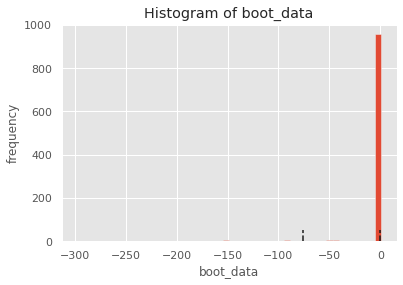

p_value =  0.8425279047098214

Уровень значимости больше 0.05
Не отклоняем H0


,0
0.025,-75.8625
0.975,0.0000


In [31]:
booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.median)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

- $1$ - В обоих случаях (с медианой и со средним значениями) 0 попадает в доверительный интервал;
- $2$ -Так же уровень значимости больше 0.05.

Следовательно, средние чеки в контрольной и тестовой группах эквивалентны.

**Итог:** ARPPU тестовой группы равен ARPPU контрольной.

# Вывод по ARPPU:

В случае с активными пользователями - средний чек увеличился.

Неактивные пользователи покупали товар по старой цене.

# ARPU - Средний доход с привлечённого пользователя

                                                   Общие данные

In [32]:
arpu_a = arppu_a * (cr_a/100)
arpu_b = arppu_b * (cr_b/100)
print('ARPU контрольной группы:',arpu_a.round(2))
print('ARPU тестовой группы:',arpu_b.round(2))

ARPU контрольной группы: 6.34
ARPU тестовой группы: 8.11


Средний доход с привлеченных пользователей в тестовой группе больше, чем в контрольной группе на 1.77.

Сформулируем гипотезы:
- $H_0$: средний доход с привлечённого пользователя в контрольной и тестовой группах **одинаковый**;
- $H_1$: средний доход с привлечённого пользователя в контрольной и тестовой группах **различны**.

                                                       Russia

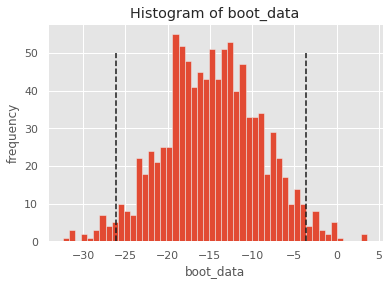

p_value =  0.010743967597218695

Уровень значимости меньше 0.05
Отклоняем H0


,0
0.025,-26.135864
0.975,-3.623375


In [33]:
control = general_data.query('group == "A" and country == "Russia"').revenue
test = general_data.query('group == "B" and country == "Russia"').revenue

booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.mean)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

                                                       Sweden

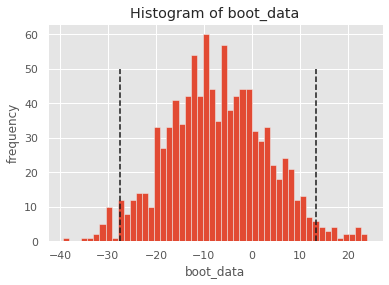

p_value =  0.48418858144886856

Уровень значимости больше 0.05
Не отклоняем H0


,0
0.025,-27.486251
0.975,13.390859


In [34]:
control = general_data.query('group == "A" and country == "Sweden"').revenue
test = general_data.query('group == "B" and country == "Sweden"').revenue

booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.mean)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

                                                 Неактивные пользователи

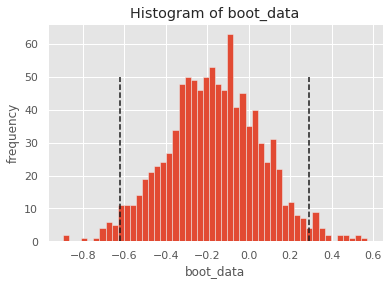

p_value =  0.4581882622433292

Уровень значимости больше 0.05
Не отклоняем H0


,0
0.025,-0.620914
0.975,0.289120


In [35]:
control = general_data.query('group == "A" and country != "Sweden" and country != "Russia"').revenue
test = general_data.query('group == "B" and country != "Sweden" and country != "Russia"').revenue

booted_data = get_bootstrap(control, test, boot_it = 1000, statistic = np.mean)
print('p_value = ',booted_data['p_value'])
if booted_data['p_value'] <= 0.05:
    print('\nУровень значимости меньше 0.05\nОтклоняем H0')
else:
    print('\nУровень значимости больше 0.05\nНе отклоняем H0')
booted_data['ci']

В случае с ARPU - средний доход с пользователя вырос только в России.

В Швеции и в случае с неактивными пользователями - изменений не произошло.

# Вывод

Метрики:

- $CR$ - Конверсия пользователя в клиента (в покупку) по группам;
- $ARPPU$ - показатель средней выручки с платящего пользователя;
- $ARPU$ - показатель средней прибыли с привлечённого пользователя.

**В случае с Россией:**

Увеличились такие метрики, как ARPPU и ARPU.

Следовательно, пользователи из этой страны готовы платить больше за новую модель оплаты коллекций шаблонов.

**В Швеции:**

Увеличилась только средняя выручка с платящего пользователя. Однако средняя прибыль с привлеченного пользователя и конверсия в покупку остались такими же.

Значит, средний чек с платящего пользователя увеличился не значительно и поэтому не повлиял на остальные метрики.

**Неактивные пользователи:**

В этом случае не изменилась ни одна метрика, возможно из-за того, что у них стоит автоматическое продление подписки и даже в случае с новым способом оплаты - цена на подписку у них не изменилась.

Из-за нехватки данных, сложно судить об этой группе.

                             Метрики, которые увеличились у пользователей из России

In [36]:
arppu_a_russia = general_data.query('group == "A" and country == "Russia"').revenue.sum() \
/ general_data.query('group == "A" and revenue > 0 and country == "Russia"').revenue.count()
print('ARPPU контрольной группы в России:',arppu_a_russia.round(2))

arppu_b_russia = general_data.query('group == "B" and country == "Russia"').revenue.sum() \
/ general_data.query('group == "B" and revenue > 0 and country == "Russia"').revenue.count()
print('ARPPU тестовой группы в России:',arppu_b_russia.round(2))

ARPPU контрольной группы в России: 823.42
ARPPU тестовой группы в России: 1215.44


In [37]:
arpu_a_russia = general_data.query('group == "A" and country == "Russia"').revenue.sum() \
/ general_data.query('group == "A" and country == "Russia"').revenue.count()
print('ARPU контрольной группы в России:',arpu_a_russia.round(2))

arpu_b_russia = general_data.query('group == "B" and country == "Russia"').revenue.sum()  \
/ general_data.query('group == "B" and country == "Russia"').revenue.count()
print('ARPU тестовой группы в России:',arpu_b_russia.round(2))

ARPU контрольной группы в России: 38.7
ARPU тестовой группы в России: 53.3


                                                   В процентах

In [38]:
x = (arppu_b_russia * 100 / arppu_a_russia) - 100
print('ARPPU тестовой группы больше контрольной группы на :', x.round(2), '%\n')
y = (arpu_b_russia * 100 / arpu_a_russia) - 100
print('ARPU тестовой группы больше контрольной группы на :', y.round(2), '%')

ARPPU тестовой группы больше контрольной группы на : 47.61 %

ARPU тестовой группы больше контрольной группы на : 37.75 %


                                Метрики, которые увеличились у пользователей из Швеции

In [39]:
arppu_a_sweden = general_data.query('group == "A" and country == "Sweden"').revenue.sum() \
/ general_data.query('group == "A" and revenue > 0 and country == "Sweden"').revenue.count()
print('ARPPU контрольной группы в Швеции:',arppu_a_sweden.round(2))

arppu_b_sweden = general_data.query('group == "B" and country == "Sweden"').revenue.sum() \
/ general_data.query('group == "B" and revenue > 0 and country == "Sweden"').revenue.count()
print('ARPPU тестовой группы в Швеции:',arppu_b_sweden.round(2))

ARPPU контрольной группы в Швеции: 1091.17
ARPPU тестовой группы в Швеции: 1356.16


                                                   В процентах

In [40]:
x = (arppu_b_sweden * 100 / arppu_a_sweden) - 100
print('ARPPU тестовой группы больше контрольной группы на :', x.round(2), '%')

ARPPU тестовой группы больше контрольной группы на : 24.28 %


# Рекомендации

Новую модель оплаты можно запускать.

Данную модель можно запустить как только для пользователей из России, так и для всех остальных пользователей.

Хоть на Швецию новая модель оплаты не повлияла так сильно, как на Россию, все же средний чек увеличился больее чем на 24%.

С неактивными пользователями непонятная ситуация. О них можно судить только с более обширными данными. Но если запустить обновление на всех пользователей, то в ситуации с этими пользователями - метрики не упадут.

#  Ссылка на дашборд

https://public.tableau.com/app/profile/.41047332/viz/UserInvolvement/sheet8